In [1]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time

import root_pandas as rpd
from root_pandas import read_root

mpl.rcParams['figure.figsize'] = 6.2,3.5
mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 6
mpl.rcParams['legend.fontsize']= 15

Welcome to JupyROOT 6.15/01


In [2]:
def getRatio(df_A,df_D,df_trigger_A,df_trigger_D, variable='z_asso',trig_cut = 'z>0.5', pair_cut='',minz=0.01,maxz=0.5,nbins=20):
    #get number of pions with z>0.5
    print 'Print Trigger Cut ' ,trig_cut
    print 'Total Cut ', trig_cut + pair_cut
    
    norm_A = df_trigger_A.query(trig_cut).shape[0]
    norm_D = df_trigger_D.query(trig_cut).shape[0]
    print 'Number of triggers A', norm_A
    print 'Number of triggers D', norm_D
    
    y_A, x_conditional = np.histogram(df_A.query(trig_cut+pair_cut)[variable],bins=np.logspace(np.log10(minz), np.log10(maxz),nbins))
    y_D, x_conditional = np.histogram(df_D.query(trig_cut+pair_cut)[variable],bins=np.logspace(np.log10(minz), np.log10(maxz),nbins))
    x_conditional = (x_conditional[1:] + x_conditional[:-1])/2.0
    err_A = np.true_divide(np.sqrt(y_A),y_A)
    err_D = np.true_divide(np.sqrt(y_D),y_D)
    y_A = np.true_divide(y_A,norm_A)
    y_D = np.true_divide(y_D,norm_D)
    ratio_conditional = np.true_divide(y_A,y_D)
    error_conditional = np.multiply(ratio_conditional, np.sqrt(np.power(err_A,2.0) + np.power(err_D,2.0)))
    
    return ratio_conditional,error_conditional,x_conditional

In [3]:
def applyCut(inputDataframe, cut, text=None):
    nbeforecut = inputDataframe.shape[0]
    if nbeforecut>0:
        cutDataframe = inputDataframe.query(cut)
        if text:
            print text, cutDataframe.shape[0], ' (%2.2f '%(100.0*cutDataframe.shape[0]/nbeforecut), '%)'
    return cutDataframe
def applyCuts(fullDataframe,name='default',isMC=False): 
    dataframe = fullDataframe
    print 'Entries before cut ', dataframe.shape[0]
    dataframe.eval('inelasticity = Nu/27.6', inplace=True)
    dataframe.eval('E = z*Nu', inplace=True)
    dataframe.eval('P = sqrt(E*E-0.140*0.140)', inplace=True)
    
    dataframe = applyCut(dataframe, 'Q2>1.0', 'Q2>1.0 :')
    dataframe = applyCut(dataframe, 'Nu>7.0', ' Nu > 7')
    dataframe = applyCut(dataframe, 'z>0.5', 'z>0.5 :')
    dataframe = applyCut(dataframe, 'P >1.4 ', 'P>1.4 ')
    #dataframe = applyCut(dataframe, 'inelasticity<0.85','inelasticity < 0.85')
    return dataframe

def applyCutsPair(fullDataframe,name='default',isMC=False):
    print 'Starting election on dipion variables'
    if (isMC):
        print 'This is MC'
    else: 
        print 'This is Data'
    
    dataframe = fullDataframe
    dataframe.eval('z_tot = z+z_asso', inplace=True)
    dataframe.eval('E_asso = z_asso*Nu', inplace=True)
    dataframe.eval('P_asso = sqrt(E_asso*E_asso-0.140*0.140)', inplace=True)
    dataframe.eval('d = sqrt(pos_x*pos_x+pos_y*pos_y + pos_z*pos_z)', inplace=True)
    dataframe.eval('d_asso = sqrt(pos_x_asso*pos_x_asso+pos_y_asso*pos_y_asso + pos_z_asso*pos_z_asso)', inplace=True)

    dataframe.eval('dt= sqrt(pos_x*pos_x+pos_y*pos_y )', inplace=True)
    dataframe.eval('dt_asso = sqrt(pos_x_asso*pos_x_asso+pos_y_asso*pos_y_asso)', inplace=True)  
    
    dataframe = applyCut(dataframe, 'Q2>1.0', 'Q2>1.0 :')
    dataframe = applyCut(dataframe, 'Nu>7.0', ' Nu > 7')
    dataframe = applyCut(dataframe, 'z>0.5', 'z>0.5 :')
    dataframe = applyCut(dataframe, 'P >1.4 ', 'P>1.4 ')
    dataframe = applyCut(dataframe, 'P_asso >1.4 ', 'P_asso>1.4 ')

    #dataframe = applyCut(dataframe, 'pid*pid_asso<0', 'Opposite sign pairs')
    
    return dataframe

def printPairBreakdown(dataframe):
    allpairs = 1.0*dataframe.shape[0]
    print 'All pairs ', allpairs
    print 'Pairs with Leading pi+', np.true_divide(dataframe.query('pid==211').shape[0],allpairs)
    print 'Pairs with Leading pi-', dataframe.query('pid==-211').shape[0]/allpairs
    print 'Pairs with Sub-Leading pi+', dataframe.query('pid_asso==211').shape[0]/allpairs
    print 'Pairs with Sub-Leading pi-', dataframe.query('pid_asso==-211').shape[0]/allpairs
    print 'pi+ pi+ pairs',dataframe.query('pid==211 and pid_asso==211').shape[0]/allpairs
    print 'pi- pi- pairs',dataframe.query('pid==-211 and pid_asso==-211').shape[0]/allpairs
    print 'pi+ pi- pairs',dataframe.query('pid==211 and pid_asso==-211').shape[0]/allpairs
    print 'pi- pi+ pairs',dataframe.query('pid==-211 and pid_asso==211').shape[0]/allpairs
    print '//////////////////////////////////////////////////////'
    return 


## Get data from Ntuples to dataframes

In [4]:
#this needs to be read in chunks otherwise it uses all memory. (from https://github.com/scikit-hep/root_pandas)
def getdatainChunks(filename,treename):
    dataframe =pd.DataFrame()
    for df in read_root(filename, treename, chunksize=100000) :
        #print df.shape[0]
        dataframe = pd.concat([dataframe,df])
    
    print dataframe.shape[0]
    return dataframe
    

## GiBUU 

In [5]:
df = {}
df_trigger = {}
for target in ['D','Kr','Xe']:#,'Pb']:
    #GiBUU
    print target
    print ' trigger'
    df_trigger['GiBUU_%s_trigger'%target]= getdatainChunks('GiBUU_Pairs_HERMES_%s.root'%target, '%s_trigger'%target)
    print ' pairs'
    df['GiBUU_%s'%target]= getdatainChunks('GiBUU_Pairs_HERMES_%s.root'%target, target)
print df.keys()



#dataframees with pairs
for key in df.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True
    print key
    
    df[key] = applyCuts(df[key],isMC=isMC)
    df[key] = applyCutsPair(df[key],isMC=isMC)
    print ' '

D
 trigger
222015
 pairs
373492
Kr
 trigger
54325
 pairs
98831
Xe
 trigger
59957
 pairs
111011
['GiBUU_Kr', 'GiBUU_Xe', 'GiBUU_D']
GiBUU_Kr
Entries before cut  98831
Q2>1.0 : 98831  (100.00  %)
 Nu > 7 98831  (100.00  %)
z>0.5 : 98831  (100.00  %)
P>1.4  98831  (100.00  %)
Starting election on dipion variables
This is MC
Q2>1.0 : 98831  (100.00  %)
 Nu > 7 98831  (100.00  %)
z>0.5 : 98831  (100.00  %)
P>1.4  98831  (100.00  %)
P_asso>1.4  21946  (22.21  %)
 
GiBUU_Xe
Entries before cut  111011
Q2>1.0 : 111011  (100.00  %)
 Nu > 7 111011  (100.00  %)
z>0.5 : 111011  (100.00  %)
P>1.4  111011  (100.00  %)
Starting election on dipion variables
This is MC
Q2>1.0 : 111011  (100.00  %)
 Nu > 7 111011  (100.00  %)
z>0.5 : 111011  (100.00  %)
P>1.4  111011  (100.00  %)
P_asso>1.4  23578  (21.24  %)
 
GiBUU_D
Entries before cut  373492
Q2>1.0 : 373492  (100.00  %)
 Nu > 7 373492  (100.00  %)
z>0.5 : 373492  (100.00  %)
P>1.4  373492  (100.00  %)
Starting election on dipion variables
This is MC


## Apply selection for pair ntuples

['GiBUU_Kr', 'GiBUU_Xe', 'GiBUU_D']


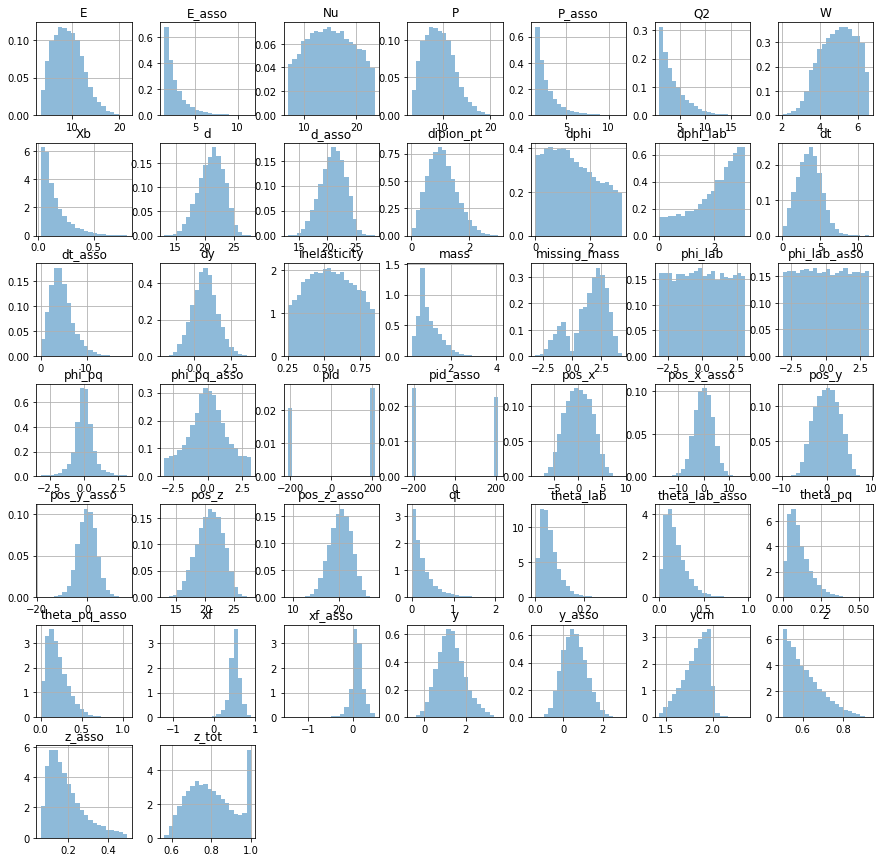

In [6]:
print df.keys()
df['GiBUU_Kr'].hist(figsize=(15, 15),normed=True,alpha=0.5,bins=20)
plt.show()

## R_2h data from HERMES and Neutrino buble-chamber experiment

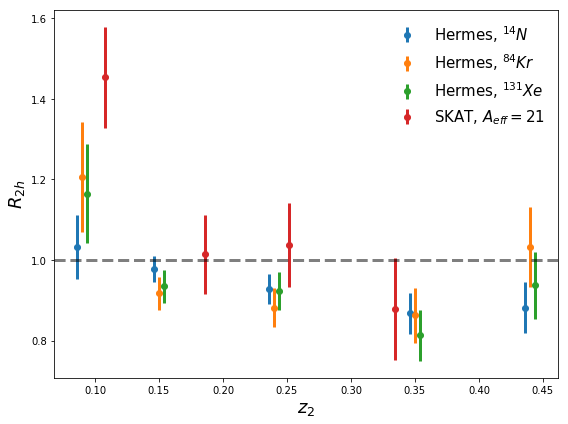

In [7]:
#hermes data:
hermes_y = {}
hermes_ystat = {}
hermes_ysyst = {}
hermes_ytotal = {}

#DATA FROM SELECTIO1 OF http://www-hermes.desy.de/notes/pub/publications.html
hermes_x = {}
hermes_x['Kr'] = [0.09,0.15,0.24,0.35,0.44]
hermes_x['N'] = np.subtract(hermes_x['Kr'],0.004)
hermes_x['Xe'] = np.subtract(hermes_x['Kr'],-0.004)

#nitrogen, atomic number 7
hermes_y['N']     = [1.0324, 0.9781,0.9293,0.8678,0.8822]
hermes_ystat['N'] = [0.0767,0.0268,0.0323,0.0478,0.0601]
hermes_ysyst['N'] = [0.0206,0.0196,0.0186,0.0174,0.0176]
hermes_ytotal['N'] = np.sqrt(np.power(hermes_ystat['N'],2.0)+np.power(hermes_ysyst['N'],2.0))

#krypton, atomic number 36
hermes_y['Kr'] = [1.2072,0.9180,0.8822,0.8631,1.0314]
hermes_ystat['Kr'] = [0.1342,0.0366,0.0452,0.0661,0.0972]
hermes_ysyst['Kr'] =[0.0241,0.0184,0.0176,0.0173,0.0206]
hermes_ytotal['Kr'] = np.sqrt(np.power(hermes_ystat['Kr'],2.0)+np.power(hermes_ysyst['Kr'],2.0))

hermes_y['Xe'] = [1.1648,0.9345,0.9242,0.8128,0.9373]
hermes_ystat['Xe'] = [0.1205,0.0359,0.0433,0.0614,0.0808]
hermes_ysyst['Xe'] = [0.0233,0.0187,0.0185,0.0163,0.0187]
hermes_ytotal['Xe'] = np.sqrt(np.power(hermes_ystat['Xe'],2.0)+np.power(hermes_ysyst['Xe'],2.0))


neutrino_x = [0.10763636363636367, 0.18618181818181817,0.25163636363636366,0.3345454545454546]
neutrino_y = [1.4535664335664338, 1.0148378893833438,  1.0373426573426574, 0.8784361093452003]
neutrino_yerror =[1.5794405594405596, 1.112739987285442, 1.1422377622377624,1.004310235219326]
neutrino_yerror = np.subtract(neutrino_yerror,neutrino_y)

fig = plt.figure(figsize=(8,6))



plt.errorbar(hermes_x['N'], hermes_y['N'],yerr=hermes_ytotal['N'],label='Hermes, $^{14}N$',fmt='o')
plt.errorbar(hermes_x['Kr'], hermes_y['Kr'],yerr=hermes_ytotal['Kr'],label='Hermes, $^{84}Kr$',fmt='o')
plt.errorbar(hermes_x['Xe'], hermes_y['Xe'],yerr=hermes_ytotal['Xe'],label='Hermes, $^{131}Xe$',fmt='o')
plt.errorbar(neutrino_x, neutrino_y,yerr=neutrino_yerror,label='SKAT, $A_{eff}=21$',fmt='o')
plt.xlabel('$z_{2}$',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)
plt.axhline(y=1.0,color='black',linestyle='--',alpha=0.5)

plt.tight_layout()
plt.legend(frameon=False)
plt.savefig('PreviousData.png')
plt.show()

Print Trigger Cut  z>0.5
Total Cut  z>0.5
Number of triggers A 54325
Number of triggers D 222015


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


Print Trigger Cut  z>0.5
Total Cut  z>0.5
Number of triggers A 59957
Number of triggers D 222015


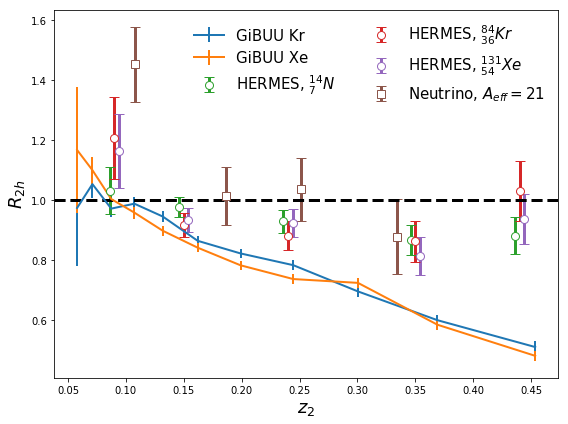

In [8]:
fig = plt.figure(figsize=(8,6))

for target in ['Kr','Xe']:
    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'])
    plt.errorbar(x,r,yerr=err,label='GiBUU %s'%target,ms=8,lw=2)

plt.xlabel('$z_{2}$',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)

plt.errorbar(hermes_x['N'], hermes_y['N'],yerr=hermes_ytotal['N'],fmt='o',mfc='white',label='HERMES, $^{14}_{7}N$',fillstyle=None,ms=8,capsize=5)
plt.errorbar(hermes_x['Kr'], hermes_y['Kr'],yerr=hermes_ytotal['Kr'],fmt='o',mfc='white',label='HERMES, $^{84}_{36}Kr$',fillstyle=None,ms=8,capsize=5)
plt.errorbar(hermes_x['Xe'], hermes_y['Xe'],yerr=hermes_ytotal['Xe'],fmt='o',mfc='white',label='HERMES, $^{131}_{54}Xe$',fillstyle=None,ms=8,capsize=5)
plt.errorbar(neutrino_x, neutrino_y,yerr=neutrino_yerror,fmt='s',mfc='white',label='Neutrino, $A_{eff}=21$',fillstyle=None,ms=8,capsize=5)

#plt.ylim([0.5,1.5])
#plt.xlim([0.00,0.5])
plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='best',frameon=False,fontsize=15,ncol=2)

plt.tight_layout()
plt.savefig('ComparisonWithHermes_Linear.png')
#plt.xlim([0.05,0.5])

#plt.xscale('log')
#plt.savefig('ComparisonWithHermes_Log.png')

plt.show()

## Theory only

Print Trigger Cut  z>0.5
Total Cut  z>0.5
Number of triggers A 54325
Number of triggers D 222015


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


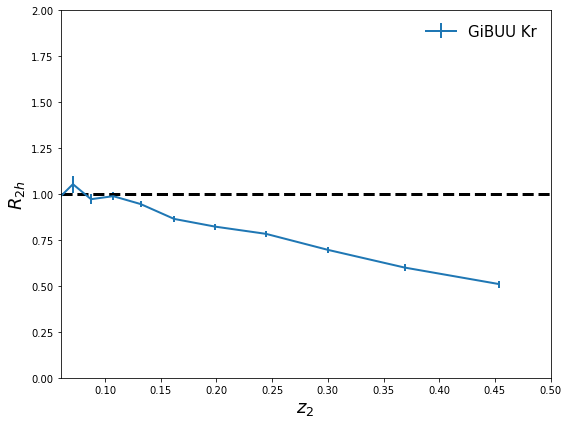

In [9]:
fig = plt.figure(figsize=(8,6))

for target in ['Kr']:
    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'])
    plt.errorbar(x,r,yerr=err,label='GiBUU %s'%target,ms=8,lw=2)

plt.xlabel('$z_{2}$',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)

plt.xlim([0.06,0.5])
plt.ylim([0.0,2.0])

plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='best',frameon=False,fontsize=15,ncol=1)


#plt.xscale('log')

plt.tight_layout()
plt.savefig('TheoryOnly.png')

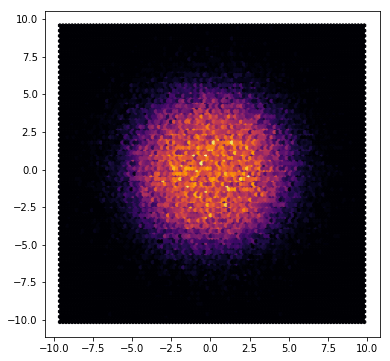

In [16]:
fig1 = plt.figure(1,figsize=(6,6))

plt.hexbin(df_trigger['GiBUU_Kr_trigger']['pos_x'],df_trigger['GiBUU_Kr_trigger']['pos_y'],cmap='inferno')


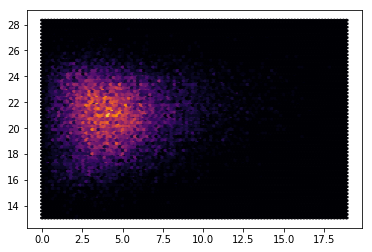

In [15]:
df_cut = df['GiBUU_Kr'].query('z>0.5')
plt.hexbin(df_cut['dt_asso'],df_cut['d_asso'],cmap='inferno')


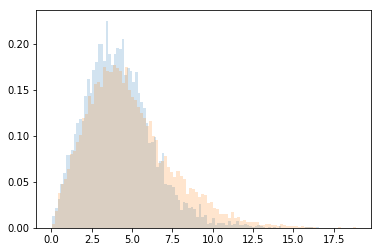

In [12]:
df_cut = df['GiBUU_Kr'].query('z_asso>0.2')
plt.hist(df_cut['dt_asso'],bins=100,alpha=0.2, normed=True)
df_cut = df['GiBUU_Kr'].query('z_asso<0.2')
plt.hist(df_cut['dt_asso'],bins=100,alpha=0.2, normed=True)
plt.show()